In [1]:
import pandas as pd
import openpyxl
import h5py
import cv2
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
import sys
import os
import random 
import warnings
import math
from functools import partial

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## Experiment Hyperparameters

In [2]:
is_local = True # todo

# Experiment
seed = 1000 if is_local else int(sys.argv[-2])
torch.manual_seed(seed)
image_size = 256

# Data: which wavenumbers are even allowed to be considered?
wv_start = 0
wv_end = 965

# Data loading
test_set_fraction = 0.2
val_set_fraction = 0.2
batch_size= 64
patch_dim = 101
use_augmentation = True

# Network
dropout_p=0.5

# Training schedule
lr = 5e-4
l2 = 5e-2
max_iters = 5000
pseudo_epoch = 100

# dimensionality reduction parameters
r_method = 'linear' # {'linear','pca,'fixed'}
reduce_dim = 16 if is_local else int(sys.argv[-1]) # used only for r_method = 'pca' or 'linear'
channels_used = np.s_[...,:] # used only when r_method = 'fixed'
print(channels_used)

(Ellipsis, slice(None, None, None))


In [3]:
def csf_fp(filepath):
    return filepath.replace('D:/datasets','D:/datasets' if is_local else './')

master = pd.read_excel(csf_fp(rf'D:/datasets/pcuk2023_ftir_whole_core/master_sheet.xlsx'))
slide = master['slide'].to_numpy()
patient_id = master['patient_id'].to_numpy()
hdf5_filepaths = np.array([csf_fp(fp) for fp in master['hdf5_filepath']])
annotation_filepaths = np.array([csf_fp(fp) for fp in master['annotation_filepath']])
mask_filepaths = np.array([csf_fp(fp) for fp in master['mask_filepath']])
wavenumbers = np.load(csf_fp(f'D:/datasets/pcuk2023_ftir_whole_core/wavenumbers.npy'))[wv_start:wv_end]
wavenumbers_used = wavenumbers[channels_used]

annotation_class_colors = np.array([[0,255,0],[128,0,128],[255,0,255],[0,0,255],[255,165,0],[255,0,0]])
annotation_class_names = np.array(['epithelium_n','stroma_n','epithelium_c','stroma_c','corpora_amylacea','blood'])
n_classes = len(annotation_class_names)
print(f"Loaded {len(slide)} cores")
print(f"Using {len(wavenumbers_used)}/{len(wavenumbers)} wavenumbers")

Loaded 228 cores
Using 965/965 wavenumbers


## Define Datasets, Dataloaders

In [4]:
unique_pids = np.unique(patient_id)
pids_trainval, pids_test, _, _ = train_test_split(
    unique_pids, np.zeros_like(unique_pids), test_size=test_set_fraction, random_state=seed)
pids_train, pids_val, _, _ = train_test_split(
    pids_trainval, np.zeros_like(pids_trainval), test_size=(val_set_fraction/(1-test_set_fraction)), random_state=seed)
where_train = np.where(np.isin(patient_id,pids_train))
where_val = np.where(np.isin(patient_id,pids_val))
where_test = np.where(np.isin(patient_id,pids_test))
print(f"Patients per data split:\n\tTRAIN: {len(where_train[0])}\n\tVAL: {len(where_val[0])}\n\tTEST: {len(where_test[0])}")

Patients per data split:
	TRAIN: 130
	VAL: 51
	TEST: 47


In [5]:
class ftir_patching_dataset(torch.utils.data.Dataset):
    def __init__(self,hdf5_filepaths, mask_filepaths, annotation_filepaths, channels_use,
                 patch_dim=25, augment=True,):
        
        # Define data paths
        self.hdf5_filepaths = hdf5_filepaths
        self.mask_filepaths = mask_filepaths
        self.annotation_filepaths = annotation_filepaths
        self.augment = augment
        
        # patch dimensions
        self.patch_dim = patch_dim
        self.patch_minus = patch_dim //2; self.patch_plus = 1 + (patch_dim // 2)
        self.channels = channels_use
        
        # class data
        self.annotation_class_colors = annotation_class_colors
        self.annotation_class_names = annotation_class_names
        self.total_sampled = torch.zeros(len(self.annotation_class_colors))
        
        # define data augmentation pipeline
        self.transforms = v2.Compose([
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomVerticalFlip(p=0.5),
        ])
        
        # Open every core hdf5 file
        self.open()
        
    def __len__(self):
        return self.total_pixels
    
    def __getitem__(self,idx):
        # get patch data
        row = self.rows[idx]
        col = self.cols[idx]
        cidx = self.cidxs[idx]
        label = self.tissue_classes[idx]
        self.total_sampled[label] += 1
        
        # Are dimensions of patch okay
        idx_u = row - self.patch_minus
        idx_d = row + self.patch_plus
        idx_l = col - self.patch_minus
        idx_r = col + self.patch_plus
        pad_u = max(-idx_u,0); idx_u = max(idx_u,0)
        pad_d = max(idx_d-image_size,0); idx_d = min(idx_d,image_size)
        pad_l = max(-idx_l,0); idx_l = max(idx_l,0)
        pad_r = max(idx_r-image_size,0); idx_r = min(idx_r,image_size)
        
        # get patch
        patch = torch.from_numpy(
            self.hdf5_files[cidx]['spectra'][idx_u:idx_d,idx_l:idx_r,*self.channels],
        ).permute(2,0,1)
        patch *= torch.from_numpy(
            self.hdf5_files[cidx]['mask'][idx_u:idx_d,idx_l:idx_r,],
        ).unsqueeze(0)
        
        # pad patch
        patch = torch.nn.functional.pad(patch,(pad_l,pad_r,pad_u,pad_d,0,0))
        
        if self.augment:
            patch = self.transforms(patch)
        return patch,label

    # split annotations from H x W x 3 to C x H x W, one/zerohot along C dimension
    def split_annotations(self,annotations_img):
        split = torch.zeros((len(self.annotation_class_colors),*annotations_img.shape[:-1]))
        for c,col in enumerate(annotation_class_colors):
            split[c,:,:] = torch.from_numpy(np.all(annotations_img == self.annotation_class_colors[c],axis=-1)) 
        return split
    
    # open every file 
    def open(self):
        self.hdf5_files = []
        self.tissue_classes = []
        self.rows = []
        self.cols = []
        self.cidxs = []
        
        # for every core in dataset,
        for cidx in range(0,len(self.hdf5_filepaths)):
            # open annotations and remove edges and non-tissue px
            annotation = self.split_annotations(cv2.imread(self.annotation_filepaths[cidx])[:,:,::-1])
            mask = torch.from_numpy(cv2.imread(self.mask_filepaths[cidx])[:,:,1]) / 255
            annotation *= mask
            # for every class,
            for cls in range(len(annotation_class_names)):
                # get location of annotations, append to lists
                r,c = torch.where(annotation[cls])
                num_cls = annotation[cls].sum().int().item()
                self.tissue_classes.extend([cls,]*num_cls)
                self.cidxs.extend([cidx,]*num_cls)
                self.rows.extend(r)
                self.cols.extend(c)
            # add open hdf5 file to list
            self.hdf5_files.append(h5py.File(self.hdf5_filepaths[cidx],'r'))
                
        # construct data tensors
        self.rows = torch.Tensor(self.rows).int()
        self.cols = torch.Tensor(self.cols).int()
        self.tissue_classes = torch.Tensor(self.tissue_classes).long()
        self.cidxs = torch.Tensor(self.cidxs).int()
        self.total_pixels = len(self.cidxs)

    # close every open hdf5 file
    def close(self):
        for cidx in range(len(self.hdf5_files)):
            self.hdf5_files[cidx].close()
        self.hdf5_files = []
        self.tissue_classes = []
        self.xs = []
        self.ys = []

In [6]:
dataset_train = ftir_patching_dataset(
    hdf5_filepaths[where_train], mask_filepaths[where_train], annotation_filepaths[where_train], channels_used,
    patch_dim = patch_dim, augment=use_augmentation,
)
dataset_val = ftir_patching_dataset(
    hdf5_filepaths[where_val], mask_filepaths[where_val], annotation_filepaths[where_val], channels_used,
    patch_dim = patch_dim, augment=False,
)
dataset_test = ftir_patching_dataset(
    hdf5_filepaths[where_test], mask_filepaths[where_test], annotation_filepaths[where_test], channels_used,
    patch_dim = patch_dim, augment=False,
)

# Instiantiate data loaders
_, class_counts = np.unique(dataset_train.tissue_classes, return_counts=True)
class_weights = 1 / class_counts
class_weights = class_weights[dataset_train.tissue_classes]
train_sampler = torch.utils.data.WeightedRandomSampler(class_weights, len(class_weights), replacement=True)

_, class_counts = np.unique(dataset_val.tissue_classes, return_counts=True)
class_weights = 1 / class_counts
class_weights = class_weights[dataset_val.tissue_classes]
val_sampler = torch.utils.data.WeightedRandomSampler(class_weights, len(class_weights), replacement=True)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=train_sampler,drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, sampler=val_sampler,drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size,shuffle=True,drop_last=True)
print(f"loader sizes:\n\ttrain: {len(train_loader)}\n\tval: {len(val_loader)}\n\ttest: {len(test_loader)}")

loader sizes:
	train: 5460
	val: 2221
	test: 2117


## Define dimensionality reduction method

In [7]:
class LinearReduction(nn.Module):
    def __init__(self,input_dim,reduce_dim):
        super().__init__()
        self.reduce_dim = reduce_dim
        self.input_norm = nn.BatchNorm2d(input_dim)
        self.projection = nn.Conv2d(input_dim,reduce_dim,kernel_size=1,stride=1)
        self.projection_norm = nn.BatchNorm2d(reduce_dim)
    
    def forward(self,x):
        return self.projection_norm(self.projection(self.input_norm(x)))
    
class PCAReduce(nn.Module):
    def __init__(self,reduce_dim,means,loadings):
        super().__init__()
        self.reduce_dim = reduce_dim
        self.register_buffer('means', torch.from_numpy(means).float().reshape(1,-1,1,1))
        self.register_buffer('loadings', torch.from_numpy(loadings).float())
    
    def forward(self,x):
        projected = x - self.means
        
        b,c,h,w = projected.shape
        projected = projected.permute(0,2,3,1).reshape(b,h*w,c)
        projected = torch.matmul(projected, self.loadings.T)
        projected = projected.reshape(b,h,w,self.reduce_dim).permute(0,3,1,2)
        
        return projected
        
class FixedReduction(nn.Module):
    def __init__(self,input_dim):
        super().__init__()
        self.input_norm = nn.BatchNorm2d(input_dim)
    
    def forward(self,x):
        return self.input_norm(x)

if r_method == 'pca':
    spectral_sample = []
    batch_samples = 0
    for data, annotations, mask, has_annotations in train_loader:
        where = torch.where(has_annotations[0] == 1)
        ridxs = torch.randperm(where[0].shape[0])[:100]
        spectral_sample.append(data[:, :, where[0][ridxs],where[1][ridxs]].permute(0,2,1).flatten(0,1).numpy())
        batch_samples += 1
        if batch_samples > 10: break
    spectral_sample = np.concatenate(spectral_sample,axis=0)
    spectral_means = np.mean(spectral_sample,axis=0)
    spectral_sample -= spectral_means
    pca = PCA(n_components=reduce_dim)
    pca.fit(spectral_sample)
    spectral_loadings = pca.components_
    
if r_method == 'pca':
    input_processing = PCAReduce(reduce_dim,spectral_means,spectral_loadings)
elif r_method == 'fixed':
    input_processing = FixedReduction(input_dim=len(wavenumbers_used))
elif r_method == 'linear':
    input_processing = LinearReduction(input_dim=len(wavenumbers_used),reduce_dim=reduce_dim)

## Define Model

In [8]:
def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    # Cut & paste from PyTorch official master until it's in a few official releases - RW
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn(
            "mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
            "The distribution of values may be incorrect.",
            stacklevel=2,
        )

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.0))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor

def trunc_normal_(tensor, mean=0.0, std=1.0, a=-2.0, b=2.0):
    # type: (Tensor, float, float, float, float) -> Tensor
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)

class PatchEmbedPerChannel(nn.Module):
    """Image to Patch Embedding."""

    def __init__(
        self,
        img_size: int = 224,
        patch_size: int = 16,
        in_chans: int = 3,
        embed_dim: int = 768,
        enable_sample: bool = True,
    ):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size) * in_chans
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv3d(
            1,
            embed_dim,
            kernel_size=(1, patch_size, patch_size),
            stride=(1, patch_size, patch_size),
        )  # CHANGED

        self.channel_embed = nn.Embedding(in_chans, embed_dim)
        self.enable_sample = enable_sample

        trunc_normal_(self.channel_embed.weight, std=0.02)

    def forward(self, x, extra_tokens={}):
        # # assume all images in the same batch has the same input channels
        # cur_channels = extra_tokens["channels"][0]
        # embedding lookup
        cur_channel_embed = self.channel_embed(
            extra_tokens["channels"]
        )  # B, Cin, embed_dim=Cout
        cur_channel_embed = cur_channel_embed.permute(0, 2, 1)  # B Cout Cin

        B, Cin, H, W = x.shape
        # Note: The current number of channels (Cin) can be smaller or equal to in_chans

        if self.training and self.enable_sample:
            # Per batch channel sampling
            # Note this may be slow
            # Randomly sample the number of channels for this batch
            Cin_new = random.randint(1, Cin)

            # Randomly sample the selected channels
            channels = random.sample(range(Cin), k=Cin_new)
            
            Cin = Cin_new
            x = x[:, channels, :, :]

            # Update the embedding lookup
            cur_channel_embed = cur_channel_embed[:, :, channels]
            ######

        # shared projection layer across channels
        x = self.proj(x.unsqueeze(1))  # B Cout Cin H W

        # channel specific offsets
        x += cur_channel_embed.unsqueeze(-1).unsqueeze(-1)
        # x += self.channel_embed[:, :, cur_channels, :, :]  # B Cout Cin H W

        # preparing the output sequence
        x = x.flatten(2)  # B Cout CinHW
        x = x.transpose(1, 2)  # B CinHW Cout

        return x, Cin

class Attention(nn.Module):
    def __init__(
        self,
        dim,
        num_heads=8,
        qkv_bias=False,
        qk_scale=None,
        attn_drop=0.0,
        proj_drop=0.0,
    ):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.num_heads, C // self.num_heads)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn
    
class Mlp(nn.Module):
    def __init__(
        self,
        in_features,
        hidden_features=None,
        out_features=None,
        act_layer=nn.GELU,
        drop=0.0,
    ):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x    

def drop_path(x, drop_prob: float = 0.0, training: bool = False):
    if drop_prob == 0.0 or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (
        x.ndim - 1
    )  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output

class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks)."""

    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

class Block(nn.Module):
    def __init__(
        self,
        dim,
        num_heads,
        mlp_ratio=4.0,
        qkv_bias=False,
        qk_scale=None,
        drop=0.0,
        attn_drop=0.0,
        drop_path=0.0,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
    ):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            attn_drop=attn_drop,
            proj_drop=drop,
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(
            in_features=dim,
            hidden_features=mlp_hidden_dim,
            act_layer=act_layer,
            drop=drop,
        )

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class ChannelVisionTransformer(nn.Module):
    """Channel Vision Transformer"""

    def __init__(
        self,
        img_size=[224],
        patch_size=16,
        in_chans=3,
        num_classes=0,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4.0,
        qkv_bias=False,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.0,
        norm_layer=nn.LayerNorm,
        enable_sample=True,
        **kwargs,
    ):
        super().__init__()
        print(
            "Warning!!!\n"
            "Samplev2 channel vit randomly sample channels for each batch.\n"
            "It is only compatible with Supervised learning\n"
            "Doesn't work with DINO or Linear Prob"
        )

        self.num_features = self.embed_dim = self.out_dim = embed_dim
        self.in_chans = in_chans
        
        if r_method == 'pca':
            self.input_processing = PCAReduce(reduce_dim,spectral_means,spectral_loadings)
        elif r_method == 'fixed':
            self.input_processing = FixedReduction(input_dim=len(wavenumbers_used))
        elif r_method == 'linear':
            self.input_processing = LinearReduction(input_dim=len(wavenumbers_used),reduce_dim=reduce_dim)

        self.patch_embed = PatchEmbedPerChannel(
            img_size=img_size[0],
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
            enable_sample=enable_sample,
        )
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        self.num_extra_tokens = 1  # cls token

        self.pos_embed = nn.Parameter(
            torch.zeros(
                1, num_patches // self.in_chans + self.num_extra_tokens, embed_dim
            )
        )

        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [
            x.item() for x in torch.linspace(0, drop_path_rate, depth)
        ]  # stochastic depth decay rule
        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    num_heads=num_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    qk_scale=qk_scale,
                    drop=drop_rate,
                    attn_drop=attn_drop_rate,
                    drop_path=dpr[i],
                    norm_layer=norm_layer,
                )
                for i in range(depth)
            ]
        )
        self.norm = norm_layer(embed_dim)

        # Classifier head
        self.head = (
            nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        )

        trunc_normal_(self.pos_embed, std=0.02)
        trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def interpolate_pos_encoding(self, x, w, h, c):
        # number of auxilary dimensions before the patches
        if not hasattr(self, "num_extra_tokens"):
            # backward compatibility
            num_extra_tokens = 1
        else:
            num_extra_tokens = self.num_extra_tokens

        npatch = x.shape[1] - num_extra_tokens
        N = self.pos_embed.shape[1] - num_extra_tokens

        if npatch == N and w == h:
            return self.pos_embed

        class_pos_embed = self.pos_embed[:, :num_extra_tokens]
        patch_pos_embed = self.pos_embed[:, num_extra_tokens:]

        dim = x.shape[-1]
        w0 = w // self.patch_embed.patch_size
        h0 = h // self.patch_embed.patch_size
        # we add a small number to avoid floating point error in the interpolation
        # see discussion at https://github.com/facebookresearch/dino/issues/8
        w0, h0 = w0 + 0.1, h0 + 0.1
        patch_pos_embed = nn.functional.interpolate(
            patch_pos_embed.reshape(
                1, int(math.sqrt(N)), int(math.sqrt(N)), dim
            ).permute(0, 3, 1, 2),
            scale_factor=(w0 / math.sqrt(N), h0 / math.sqrt(N)),
            mode="bicubic",
        )
        assert (
            int(w0) == patch_pos_embed.shape[-2]
            and int(h0) == patch_pos_embed.shape[-1]
        )
        patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, 1, -1, dim)

        # create copies of the positional embeddings for each channel
        patch_pos_embed = patch_pos_embed.expand(1, c, -1, dim).reshape(1, -1, dim)

        return torch.cat((class_pos_embed, patch_pos_embed), dim=1)

    def prepare_tokens(self, x, extra_tokens):
        B, nc, w, h = x.shape
        x, nc = self.patch_embed(x, extra_tokens)  # patch linear embedding

        # add the [CLS] token to the embed patch tokens
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # add positional encoding to each token
        x = x + self.interpolate_pos_encoding(x, w, h, nc)

        return self.pos_drop(x)

    def forward(self, x, extra_tokens={}):
        x = self.input_processing(x)
        x = self.prepare_tokens(x, extra_tokens)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        return self.head(x[:, 0])
    

In [9]:
model = ChannelVisionTransformer(
    img_size=[patch_dim,],
    patch_size=16,
    in_chans=reduce_dim, # todo change if not using linear reduc
    num_classes=n_classes,
    embed_dim=192, # todo
    depth=12,
    num_heads=4,
    mlp_ratio=4,
    qkv_bias=True,
    norm_layer=partial(nn.LayerNorm, eps=1e-6),
)

model = model.to(device)
chn_tok = {"channels":torch.from_numpy(np.arange(0,reduce_dim)).unsqueeze(0).to(device)}

Warning!!!
Samplev2 channel vit randomly sample channels for each batch.
It is only compatible with Supervised learning
Doesn't work with DINO or Linear Prob


## Training Loop

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=l2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=500, threshold=0.01, cooldown=250)

In [11]:
training_losses,validation_losses = [],[]
training_accs,validation_accs = [],[]
training_f1ms,validation_f1ms = [],[]
training_f1s,validation_f1s = [],[]
lr_decreases = []
current_iters = 0
best_val_f1 = 0
best_val_iter = 0
stop_training=False

In [12]:
while current_iters < max_iters:
    for (bidx, (data, label)) in enumerate(train_loader):
        data = data.to(device); label = label.to(device)
        
        # Push through model
        model.train()
        optimizer.zero_grad()
        out = model(data,extra_tokens=chn_tok)
        
        # Calculate loss
        loss = loss_fn(out, label)
        loss.backward()
        optimizer.step()
        
        # Append log arrays
        training_losses.append(loss.item())
        pred = out.argmax(dim=1).detach().cpu().numpy()
        actual = label.cpu().numpy()
        training_accs.append(accuracy_score(actual,pred))
        training_f1ms.append(f1_score(actual, pred, average='macro'))
        training_f1s.append(f1_score(actual, pred, average=None, labels=np.arange(0,n_classes),zero_division=0))
        
        # Do validation cycle
        model.eval()
        with torch.no_grad():
            # load data
            data, label = next(iter(val_loader))
            data = data.to(device); label = label.to(device)
            
            # Push through model
            out = model(data,extra_tokens=chn_tok)
            
            # Calculate loss
            loss = loss_fn(out, label)
            
            # Append log arrays
            validation_losses.append(loss.item())
            pred = out.argmax(dim=1).detach().cpu().numpy()
            actual = label.cpu().numpy()
            validation_accs.append(accuracy_score(actual,pred))
            validation_f1ms.append(f1_score(actual, pred, average='macro'))
            validation_f1s.append(f1_score(actual, pred, average=None, labels=np.arange(0,n_classes),zero_division=0))
        
        # Print training statistics every N iters
        if current_iters % pseudo_epoch == 0:
            print(f"ON ITER: {current_iters}, metrics for last {pseudo_epoch} iters:")
            print(f"TRAIN --- | Loss: {np.mean(training_losses[-pseudo_epoch:]):.4} | OA: {np.mean(training_accs[-pseudo_epoch:]):.4} | F1M: {np.mean(training_f1ms[-pseudo_epoch:]):.4f}")
            print(f"VAL ----- | Loss: {np.mean(validation_losses[-pseudo_epoch:]):.4} | OA: {np.mean(validation_accs[-pseudo_epoch:]):.4} | F1M: {np.mean(validation_f1ms[-pseudo_epoch:]):.4f}")
        
        # If performance on validation set best so far, save model
        if np.mean(validation_f1ms[-pseudo_epoch:]) > best_val_f1:
            best_val_f1 = np.mean(validation_f1ms[-pseudo_epoch:])
            best_val_iter = current_iters
            if not is_local:
                torch.save(model.state_dict(), rf'./model_weights_{seed}.pt')
        
        # Step the scheduler based on the validation set performance
        current_iters += 1
        if current_iters > max_iters: 
            stop_training = True
            break
        if current_iters > pseudo_epoch:
            scheduler.step(np.mean(validation_f1ms[-pseudo_epoch:]))
            new_lr = optimizer.param_groups[0]['lr']
            if new_lr != lr:
                print(f"Val f1 plateaued, lr {lr} -> {new_lr}")
                lr = new_lr
                lr_decreases.append(current_iters)
                if len(lr_decreases) >= 2: 
                    stop_training = True
                    print("Val f1 decreased twice, ending training early")
                    break
    if stop_training: break

training_losses = np.array(training_losses); validation_losses = np.array(validation_losses)
training_accs = np.array(training_accs); validation_accs = np.array(validation_accs)
training_f1ms = np.array(training_f1ms); validation_f1ms = np.array(validation_f1ms)
training_f1s = np.stack(training_f1s,axis=0); validation_f1s = np.stack(validation_f1s,axis=0)
print(f"Training complete after {current_iters} iterations\n\ttotal samples       :    {current_iters*batch_size}\n\t -=-=-=-=-=-=-=-=-=-=-=-=-=-")
for cls_idx, samples_loaded in enumerate(dataset_train.total_sampled.numpy()):
    print(f"\t{annotation_class_names[cls_idx]}{(20-len(annotation_class_names[cls_idx])) * ' '}:    {int(samples_loaded)}")
print(f"Metrics for final {pseudo_epoch} iterations:")
print(f"TRAIN --- | Loss: {training_losses[-pseudo_epoch:].mean():.4f} | OA: {training_accs[-pseudo_epoch:].mean():.4f} | f1: {training_f1ms[-pseudo_epoch:].mean():.4f}")
print(f"VAL ----- | Loss: {validation_losses[-pseudo_epoch:].mean():.4f} | OA: {validation_accs[-pseudo_epoch:].mean():.4f} | f1: {validation_f1ms[-pseudo_epoch:].mean():.4f}")

ON ITER: 0, metrics for last 100 iters:
TRAIN --- | Loss: 1.826 | OA: 0.1406 | F1M: 0.0423
VAL ----- | Loss: 2.167 | OA: 0.1562 | F1M: 0.0450


KeyboardInterrupt: 

## Test Loop

In [ ]:
running_loss_test = 0
test_preds, test_targets = [], []

if not is_local:
    model.load_state_dict(torch.load(rf'./model_weights_{seed}.pt', weights_only=True))

model.eval()
with torch.no_grad():
    for batch_idx, (data, label) in enumerate(test_loader):
        print(f"Iter: {batch_idx}/{len(test_loader)}",end="\r")        
        data = data.to(device)
        label = label.to(device)

        # Push through model
        out = model(data,extra_tokens=chn_tok)
        loss = loss_fn(out, label)

        # Calculate metrics
        running_loss_test += loss.cpu().item() 
        pred = out.argmax(dim=1).detach().cpu().numpy()
        actual = label.cpu().numpy()
        test_preds.extend(pred)
        test_targets.extend(actual)

test_targets = np.array(test_targets); test_preds = np.array(test_preds)
test_loss = running_loss_test / batch_idx
test_acc = accuracy_score(test_targets, test_preds)
test_f1m = f1_score(test_targets, test_preds, average='macro')
test_f1 = f1_score(test_targets, test_preds, average=None)

print("Metrics on entire testing set:")
print(f"TEST ---- | Loss: {test_loss:.4f} | OA: {test_acc:.4f} | f1: {test_f1m:.4f}")
for cls_idx, f1 in enumerate(test_f1):
    print(f"{annotation_class_names[cls_idx]}{(20 - len(annotation_class_names[cls_idx])) * ' '} : {f1:.4f}")
print("Total samples loaded for each class during TESTING")
for cls_idx, samples_loaded in enumerate(dataset_test.total_sampled.numpy()):
    print(f"{annotation_class_names[cls_idx]}{(20-len(annotation_class_names[cls_idx])) * ' '}:    {int(samples_loaded)}")

## Evaluation

In [ ]:
def moving_average(a, n=3): # https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-python-numpy-scipy
    a = np.pad(a, ((n-1)//2,(n-1)//2 + ((n-1) % 2)), mode='edge')
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

fig,ax = plt.subplots(1,3,figsize=(16,5))
ax[0].plot(np.arange(0,len(moving_average(training_losses,n=1))),moving_average(training_losses,n=1),alpha=0.3,color='cornflowerblue')
ax[0].plot(np.arange(0,len(moving_average(training_losses,n=50))),moving_average(training_losses,n=50),alpha=1,color='cornflowerblue',label="train")
ax[0].plot(np.arange(0,len(moving_average(validation_losses,n=1))),moving_average(validation_losses,n=1),alpha=0.3,color='orange')
ax[0].plot(np.arange(0,len(moving_average(validation_losses,n=50))),moving_average(validation_losses,n=50),alpha=1,color='orange',label="validation")
ax[0].scatter(current_iters,test_loss,color='green',label="test",marker="x")
ax[0].set_title("Loss"); ax[0].legend()

ax[1].plot(np.arange(0,len(moving_average(training_accs,n=1))),moving_average(training_accs,n=1),alpha=0.3,color='cornflowerblue')
ax[1].plot(np.arange(0,len(moving_average(training_accs,n=50))),moving_average(training_accs,n=50),alpha=1,color='cornflowerblue',label="train")
ax[1].plot(np.arange(0,len(moving_average(validation_accs,n=1))),moving_average(validation_accs,n=1),alpha=0.3,color='orange')
ax[1].plot(np.arange(0,len(moving_average(validation_accs,n=50))),moving_average(validation_accs,n=50),alpha=1,color='orange',label="validation")
ax[1].scatter(current_iters,test_acc,color='green',label="test",marker="x")
ax[1].set_title("Accuracy"); ax[1].legend()

ax[2].plot(np.arange(0,len(moving_average(training_f1ms,n=1))),moving_average(training_f1ms,n=1),alpha=0.3,color='cornflowerblue')
ax[2].plot(np.arange(0,len(moving_average(training_f1ms,n=50))),moving_average(training_f1ms,n=50),alpha=1,color='cornflowerblue',label="train")
ax[2].plot(np.arange(0,len(moving_average(validation_f1ms,n=1))),moving_average(validation_f1ms,n=1),alpha=0.3,color='orange')
ax[2].plot(np.arange(0,len(moving_average(validation_f1ms,n=50))),moving_average(validation_f1ms,n=50),alpha=1,color='orange',label="validation")
ax[2].scatter(current_iters,test_f1m,color='green',label="test",marker="x")
ax[2].set_title("Macro F1 Score"); ax[2].legend()

ax[0].axvline(x=best_val_iter, ymin=0, ymax=1, color='red',alpha=0.3)
ax[1].axvline(x=best_val_iter, ymin=0, ymax=1, color='red',alpha=0.3)
ax[2].axvline(x=best_val_iter, ymin=0, ymax=1, color='red',alpha=0.3)

for lrd in lr_decreases:
    ax[0].axvline(x=lrd, ymin=0, ymax=1, color='grey',alpha=0.3)
    ax[1].axvline(x=lrd, ymin=0, ymax=1, color='grey',alpha=0.3)
    ax[2].axvline(x=lrd, ymin=0, ymax=1, color='grey',alpha=0.3)

plt.tight_layout()
if not is_local:
    plt.savefig(f'./loss_curve_{seed}.png'); plt.close(fig)

In [ ]:
training_f1s = np.stack(training_f1s,axis=0)
validation_f1s = np.stack(validation_f1s,axis=0)
fig,ax = plt.subplots(2,3,figsize=(15,5)); ax = ax.flatten()
for cls in range(n_classes):
    ax[cls].plot(np.arange(0,len(moving_average(training_f1s[:,cls],n=1))),moving_average(training_f1s[:,cls],n=1),alpha=0.3,color='k')
    ax[cls].plot(np.arange(0,len(moving_average(training_f1s[:,cls],n=50))),moving_average(training_f1s[:,cls],n=50),alpha=1,color='k',label="train")
    ax[cls].plot(np.arange(0,len(moving_average(validation_f1s[:,cls],n=1))),moving_average(validation_f1s[:,cls],n=1),alpha=0.3,color=annotation_class_colors[cls]/255)
    ax[cls].plot(np.arange(0,len(moving_average(validation_f1s[:,cls],n=50))),moving_average(validation_f1s[:,cls],n=50),alpha=1,color=annotation_class_colors[cls]/255, label="validation")
    ax[cls].scatter(current_iters,test_f1[cls],color=annotation_class_colors[cls]/255,label="test",marker="x")
    ax[cls].set_ylim(ymin=0,ymax=1)
    for lrd in lr_decreases:
        ax[cls].axvline(x=lrd, ymin=0, ymax=1, color='grey',alpha=0.5)
    ax[cls].axvline(x=best_val_iter, ymin=0, ymax=1, color='red',alpha=0.3)
fig.suptitle("Class-specific F1 scores")
plt.tight_layout()
if not is_local:
    plt.savefig(f'./loss_curve_individual_{seed}.png'); plt.close(fig)

## Finish experiment

In [ ]:
if not is_local:
    model = model.cpu()
    torch.save(model.state_dict(), rf'./model_weights_{seed}.pt')

In [ ]:
# Read existing results file
if not is_local:
    if os.path.isfile('results.txt'):
        f = open('results.txt','r')
        lines = f.readlines()
        f.close()
    else: 
        lines = [x+', \n' for x in['seed',*annotation_class_names,'overall_acc','macro_f1']]
        
    # Process files
    lines[0] = lines[0].replace('\n',str(seed) + ', \n')
    for cls in range(n_classes):
        lines[cls+1] = lines[cls+1].replace('\n',str(test_f1[cls]) + ', \n' )
    lines[n_classes+1] = lines[n_classes+1].replace('\n',str(test_acc) + ', \n')
    lines[n_classes+2] = lines[n_classes+2].replace('\n',str(test_f1m) + ', \n')
    
    f = open('results.txt','w')
    f.write(''.join(lines))
    f.close()

In [22]:
model.patch_embed.channel_embed.weight.shape

torch.Size([16, 192])

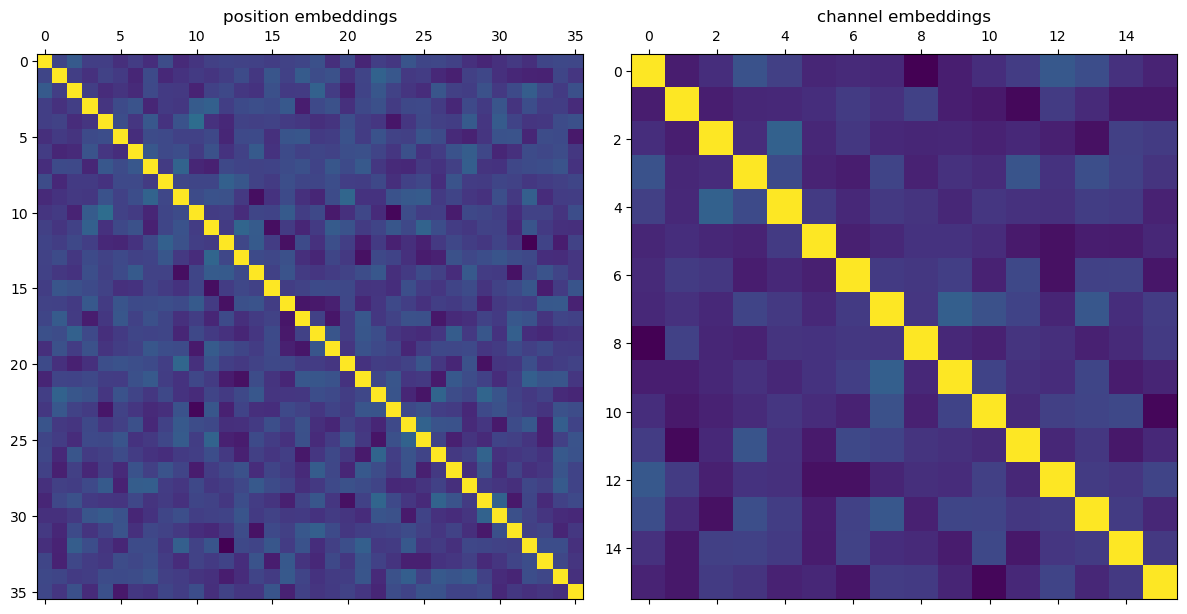

In [25]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
locarray = np.zeros((model.pos_embed.shape[1]-1,model.pos_embed.shape[1]-1))
cos = nn.CosineSimilarity(dim=0)
for r in range(model.pos_embed.shape[1]-1):
    for c in range(model.pos_embed.shape[1]-1):
        locarray[r,c] = cos(model.pos_embed[0][r + 1],model.pos_embed[0][c + 1]).detach().cpu().numpy()
chnarray = np.zeros((reduce_dim,reduce_dim))
for r in range(reduce_dim):
    for c in range(reduce_dim):
        chnarray[r,c] = cos(model.patch_embed.channel_embed.weight[r],model.patch_embed.channel_embed.weight[c]).detach().cpu().numpy()
ax[0].set_title("position embeddings"); ax[1].set_title("channel embeddings")
ax[0].matshow(locarray); ax[1].matshow(chnarray)
fig.tight_layout()
if not is_local:
    plt.savefig(f'./position_embedding_{seed}.png'); plt.close(fig) 